In [72]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [73]:
columns = ["2theta", "intensity"]

In [74]:
nacl_sample_1 = pd.read_csv('data/NaCl_sample_1.tsv', sep='\t', skiprows=1, encoding='unicode_escape')
nacl_sample_2 = pd.read_csv('data/NaCl_sample_2.tsv', sep='\t', skiprows=1, encoding='unicode_escape')
nacl_sample_3 = pd.read_csv('data/NaCl_sample_3.tsv', sep='\t', skiprows=1, encoding='unicode_escape')
samples = [nacl_sample_1, nacl_sample_2, nacl_sample_3]

Text(0.5, 23.52222222222222, '2 Theta (degrees)')

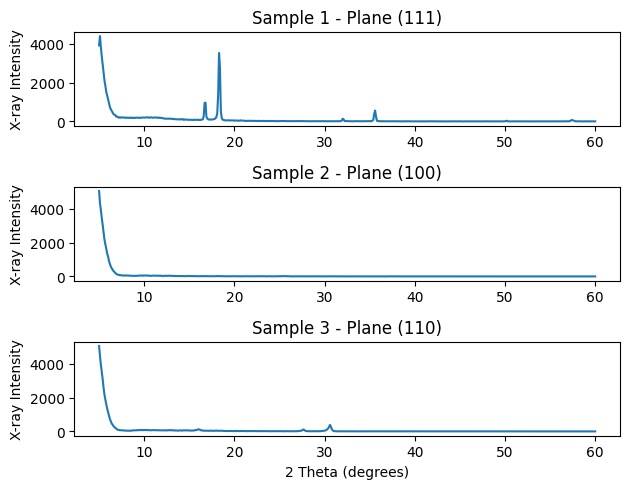

In [75]:
fig, axs = plt.subplots(nrows=len(samples))
titles = ["Plane (111)", "Plane (100)", "Plane (110)"]

for index, sample in enumerate(samples):
    sample.columns = columns
    axs[index].plot(
        sample["2theta"],
        sample["intensity"]
    )
    axs[index].set_title(f'Sample {index + 1} - {titles[index]}')
    axs[index].set_ylabel('X-ray Intensity')

plt.tight_layout()
plt.xlabel('2 Theta (degrees)')

Text(36.5, 600, '2nd Order Cu K$\\alpha$')

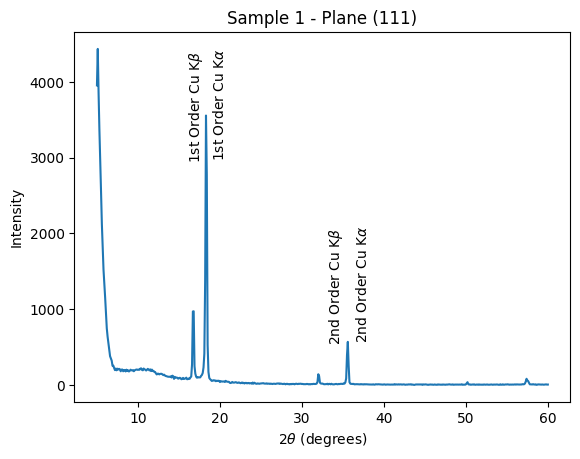

In [76]:
plt.plot(
    nacl_sample_1['2theta'],
    nacl_sample_1['intensity']
)
plt.title('Sample 1 - Plane (111)')
plt.xlabel(r'$2\theta$ (degrees)')
plt.ylabel('Intensity')

plt.text(16, 3000, r'1st Order Cu K$\beta$', rotation=90)
plt.text(19, 3000, r'1st Order Cu K$\alpha$', rotation=90)
plt.text(33, 600, r'2nd Order Cu K$\beta$', rotation=90)
plt.text(36.5, 600, r'2nd Order Cu K$\alpha$', rotation=90)

In [77]:
lattice_spacing = 5.64e-10
l_cuka = 1.54e-10
l_cukb = 1.39e-10

In [78]:
def gauss(x, A, x0, sigma):
    return A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def fit_gaussian(x, y, p0):
    popt, pcov = curve_fit(gauss, x, y, p0)
    return (popt[1], popt[2])

In [79]:
def compute_orientation_factor(theta, d_theta, order, wavelength):
    factor = 2 * lattice_spacing * np.sin(np.radians(theta)) / (order * wavelength)
    d_factor = d_theta * 2 * lattice_spacing * np.cos(np.radians(theta)) / (order * wavelength)
    return factor, d_factor

In [80]:
def lattice_spacing_111(theta, delta_theta, n, wavelength):
    a = np.sqrt(3) * n * wavelength / (2 * np.sin(np.radians(theta)))
    delta_a = delta_theta * np.sqrt(3) * n * wavelength / 2 * - np.cos(np.radians(theta)) / (np.sin(np.radians(theta)) ** 2)
    return a, abs(delta_a)

In [81]:
def compute_expected_angle_111(order, wavelength):
    return np.degrees(np.arcsin(np.sqrt(3) * order * wavelength / (2 * lattice_spacing)))

In [86]:
def print_latex_table(df):
    column_format = '|' +  '|'.join(['c']*len(df.columns)) + '|'
    string = df.to_latex(index=False, float_format=lambda x: f'{x:.2f}', column_format=column_format)
    string = string.replace('\\toprule', '\\hline').replace('\\midrule', '\\hline').replace('\\bottomrule', '\\hline')
    print(string)

In [82]:
columns = [
    "peak",
    "order",
    "wavelength",
    "theta2",
    "d_theta2",
    "theta",
    "d_theta",
    "orientation_factor",
    "d_orientation_factor",
    "a", 
    "d_a",
    "expected_angle"
]
nacl_df = pd.DataFrame(columns=columns)
sample = nacl_sample_1

In [83]:
def extract_peak_111(peak, order, wavelength, lower, upper):
    # Extract the peaks between upper and lower bounds
    data = sample[(sample["2theta"] >= lower) & (sample["2theta"] <= upper)]
    mu, sigma = fit_gaussian(data["2theta"], data["intensity"], [1000, (lower + upper) / 2, 1])
    factor, d_factor = compute_orientation_factor(mu / 2, sigma / 2, order, wavelength)
    a, delta_a = lattice_spacing_111(mu / 2, sigma / 2, order, wavelength)
    return pd.Series({
        "peak": peak,
        "order": order,
        "wavelength": wavelength * 1e10,
        "theta2": mu,
        "d_theta2": sigma,
        "theta": mu / 2,
        "d_theta": sigma / 2,
        "orientation_factor": factor,
        "d_orientation_factor": d_factor,
        "a": a * 1e10, 
        "d_a": delta_a * 1e10,
        "expected_angle": compute_expected_angle_111(order, wavelength)
    })

In [84]:
# Append all the peaks here
nacl_df = nacl_df._append(
    extract_peak_111(1, 1, l_cukb, 16, 17.5),
    ignore_index=True
)

In [87]:
columns = ["peak", "order", "wavelength", "theta2", "d_theta2", "theta", "d_theta", "expected_angle"]
measurements = nacl_df[columns].copy()
measurements.columns = [
    r"Peak",
    r"Order",
    r"Wavelength ($\AA$)",
    r"$2\theta$ (degrees)",
    r"$\Delta 2\theta$ (degrees)",
    r"$\theta$ (degrees)",
    r"$\Delta\theta$ (degrees)",
    r"$\theta_{theoretical}$ (degrees)"
]
print_latex_table(measurements)

\begin{tabular}{|c|c|c|c|c|c|c|c|}
\hline
Peak & Order & Wavelength ($\AA$) & $2\theta$ (degrees) & $\Delta 2\theta$ (degrees) & $\theta$ (degrees) & $\Delta\theta$ (degrees) & $\theta_{theoretical}$ (degrees) \\
\hline
1.00 & 1.00 & 1.39 & 16.75 & 0.09 & 8.37 & 0.05 & 12.32 \\
\hline
\end{tabular}


In [88]:
columns = ["peak", "orientation_factor", "d_orientation_factor", "a", "d_a"]
results = nacl_df[columns].copy()
results.columns = [
    r"Peak",
    r"Orientation Factor",
    r"$\Delta$ Orientation Factor",
    r"$a_{exp}$ ($\AA$)",
    r"$\Delta a_{exp}$ ($\AA$)",
]
print_latex_table(results)

\begin{tabular}{|c|c|c|c|c|}
\hline
Peak & Orientation Factor & $\Delta$ Orientation Factor & $a_{exp}$ ($\AA$) & $\Delta a_{exp}$ ($\AA$) \\
\hline
1.00 & 1.18 & 0.37 & 8.27 & 2.56 \\
\hline
\end{tabular}
